### Clone Dataset & Supporting Files

In [1]:
!git clone https://github.com/BenyaminMoadab/BasicCNN_Pytorch

'git' is not recognized as an internal or external command,
operable program or batch file.



### Importing Libraries

In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from time import time
from matplotlib import pyplot as plt
from IPython.display import display

In [3]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using:', device)

Using: cuda


### Define Datasets and Dataloaders

In [4]:
dataset_path = 'C:\\Users\\Asus\\Desktop\\Fish Classification With BasicCNN_Pytorch\\raw-img'

mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)


# Transformation function to be applied on images
# 1. Horizontally Flip the image with a probability of 30%
# 2. Randomly Rotate the image at an angle between -40 to 40 degress.
# 3. Resize each images to a smallest size of 300 pixels maintaining aspect ratio
# 4. Crop a square of size 256x256 from the center of image
# 5. Convert Image to a Pytorch Tensor
# 6. Normalize the pytorch's tensor using mean & std of imagenet
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=40),

    transforms.Resize(300),
    transforms.CenterCrop(256),

    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Create a dataset by from the dataset folder by applying the above transformation.
dataset = torchvision.datasets.ImageFolder(dataset_path, transform=transform)
# Split the dataset into train & test containing 21000 and 5179 images respectively.
train_dataset, test_dataset = torch.utils.data.random_split(dataset, (21000, 5159))

# Create a Train DataLoader using Train Dataset
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4
)
# Create a Test DataLoader using Test Dataset
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4
)

### Plot Some Samples of data

In [5]:
figsize = (16,16)

def PlotSamples(dataloader, title='Images'):
    sample_data = next(iter(dataloader))[0].to(device)
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.title(title)
    plt.imshow(np.transpose(torchvision.utils.make_grid(
        sample_data, padding=2, normalize=True
    ).cpu(), (1,2,0)))
    
    
def PlotClass(dataloader, mclass, title='Images', num=64):
    ret = []
    
    for data in dataloader.dataset:
        if data[1] == mclass:
            ret.append(data[0])
            
            if len(ret) == num:
                break
    
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.title(title)
    plt.imshow(np.transpose(torchvision.utils.make_grid(
        ret, padding=2, normalize=True
    ).cpu(), (1,2,0)))
    

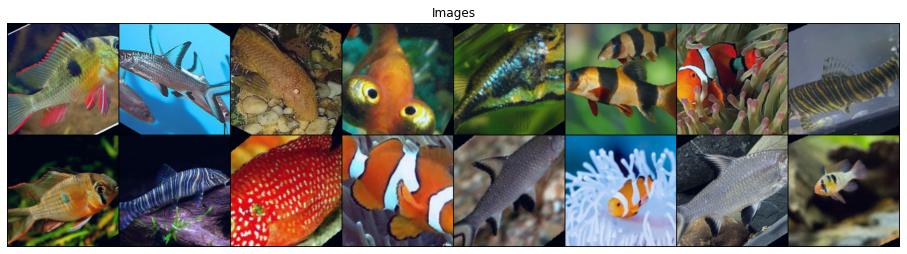

In [6]:
PlotSamples(train_dataloader)

### Defile Model Architecture

In [7]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3), nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(16, 32, kernel_size=3), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, kernel_size=3), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size=3), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128, 256, kernel_size=3), nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

        ).to(device)
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.25),
            nn.Linear(4096, 256),
            nn.ReLU(),

            nn.Dropout(0.5),
            nn.Linear(256, 10)
        ).to(device)
        
    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x


model = MyModel().to(device)
summary(model, (3,256,256))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 4, 4]           --
|    └─Conv2d: 2-1                       [-1, 16, 254, 254]        448
|    └─ReLU: 2-2                         [-1, 16, 254, 254]        --
|    └─Conv2d: 2-3                       [-1, 16, 252, 252]        2,320
|    └─ReLU: 2-4                         [-1, 16, 252, 252]        --
|    └─MaxPool2d: 2-5                    [-1, 16, 126, 126]        --
|    └─Conv2d: 2-6                       [-1, 32, 124, 124]        4,640
|    └─ReLU: 2-7                         [-1, 32, 124, 124]        --
|    └─Conv2d: 2-8                       [-1, 32, 122, 122]        9,248
|    └─ReLU: 2-9                         [-1, 32, 122, 122]        --
|    └─MaxPool2d: 2-10                   [-1, 32, 61, 61]          --
|    └─Conv2d: 2-11                      [-1, 64, 59, 59]          18,496
|    └─ReLU: 2-12                        [-1, 64, 59, 59]          --
|

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 4, 4]           --
|    └─Conv2d: 2-1                       [-1, 16, 254, 254]        448
|    └─ReLU: 2-2                         [-1, 16, 254, 254]        --
|    └─Conv2d: 2-3                       [-1, 16, 252, 252]        2,320
|    └─ReLU: 2-4                         [-1, 16, 252, 252]        --
|    └─MaxPool2d: 2-5                    [-1, 16, 126, 126]        --
|    └─Conv2d: 2-6                       [-1, 32, 124, 124]        4,640
|    └─ReLU: 2-7                         [-1, 32, 124, 124]        --
|    └─Conv2d: 2-8                       [-1, 32, 122, 122]        9,248
|    └─ReLU: 2-9                         [-1, 32, 122, 122]        --
|    └─MaxPool2d: 2-10                   [-1, 32, 61, 61]          --
|    └─Conv2d: 2-11                      [-1, 64, 59, 59]          18,496
|    └─ReLU: 2-12                        [-1, 64, 59, 59]          --
|

### Training Procedure

In [8]:
def Train(epoch, print_every=50):
    total_loss = 0
    start_time = time()
    
    accuracy = []
    
    for i, batch in enumerate(train_dataloader, 1):
        minput = batch[0].to(device) # Get batch of images from our train dataloader
        target = batch[1].to(device) # Get the corresponding target(0, 1 or 2) representing cats, dogs or pandas
        
        moutput = model(minput) # output by our model
        
        loss = criterion(moutput, target) # compute cross entropy loss
        total_loss += loss.item()

        optimizer.zero_grad() # Clear the gradients if exists. (Gradients are used for back-propogation.)
        loss.backward() # Back propogate the losses
        optimizer.step() # Update Model parameters
        
        argmax = moutput.argmax(dim=1) # Get the class index with maximum probability predicted by the model
        accuracy.append((target==argmax).sum().item() / target.shape[0]) # calculate accuracy by comparing to target tensor

        if i%print_every == 0:
            print('Epoch: [{}]/({}/{}), Train Loss: {:.4f}, Accuracy: {:.2f}, Time: {:.2f} sec'.format(
                epoch, i, len(train_dataloader), loss.item(), sum(accuracy)/len(accuracy), time()-start_time 
            ))
    
    return total_loss / len(train_dataloader) # Returning Average Training Loss

### Testing Procedure

In [9]:
def Test(epoch):
    total_loss = 0
    start_time = time()

    accuracy = []
    
    with torch.no_grad(): # disable calculations of gradients for all pytorch operations inside the block
        for i, batch in enumerate(test_dataloader):
            minput = batch[0].to(device) # Get batch of images from our test dataloader
            target = batch[1].to(device) # Get the corresponding target(0, 1 or 2) representing cats, dogs or pandas
            moutput = model(minput) # output by our model

            loss = criterion(moutput, target) # compute cross entropy loss
            total_loss += loss.item()
            
            
            # To get the probabilities for different classes we need to apply a softmax operation on moutput 
            argmax = moutput.argmax(dim=1) # Find the index(0, 1 or 2) with maximum score (which denotes class with maximum probability)
            accuracy.append((target==argmax).sum().item() / target.shape[0]) # Find the accuracy of the batch by comparing it with actual targets
            
    print('Epoch: [{}], Test Loss: {:.4f}, Accuracy: {:.2f}, Time: {:.2f} sec'.format(
        epoch, total_loss/len(test_dataloader), sum(accuracy)/len(accuracy), time()-start_time
    ))
    return total_loss/len(test_dataloader) # Returning Average Testing Loss

### Model, Optimizer & Loss Function

In [10]:
lr = 0.0001
model = MyModel().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

### Train for 50 epochs

In [11]:
Test(0)

train_loss = []
test_loss = []

for epoch in range(1, 10):
    train_loss.append(Train(epoch,200))
    test_loss.append(Test(epoch))

    print('\n')
    
    if epoch % 10 == 0:
        torch.save(model, 'model_'+str(epoch)+'.pth')

Epoch: [0], Test Loss: 2.3002, Accuracy: 0.11, Time: 18.48 sec
Epoch: [1]/(200/1313), Train Loss: 2.1270, Accuracy: 0.21, Time: 20.40 sec
Epoch: [1]/(400/1313), Train Loss: 1.8108, Accuracy: 0.26, Time: 38.34 sec
Epoch: [1]/(600/1313), Train Loss: 1.7193, Accuracy: 0.31, Time: 56.28 sec
Epoch: [1]/(800/1313), Train Loss: 1.0746, Accuracy: 0.35, Time: 74.27 sec
Epoch: [1]/(1000/1313), Train Loss: 0.9307, Accuracy: 0.38, Time: 92.31 sec
Epoch: [1]/(1200/1313), Train Loss: 1.5663, Accuracy: 0.41, Time: 110.35 sec
Epoch: [1], Test Loss: 1.2317, Accuracy: 0.55, Time: 21.46 sec


Epoch: [2]/(200/1313), Train Loss: 0.8548, Accuracy: 0.56, Time: 20.62 sec
Epoch: [2]/(400/1313), Train Loss: 1.1995, Accuracy: 0.57, Time: 38.68 sec
Epoch: [2]/(600/1313), Train Loss: 1.1179, Accuracy: 0.58, Time: 56.72 sec
Epoch: [2]/(800/1313), Train Loss: 0.9169, Accuracy: 0.59, Time: 74.84 sec
Epoch: [2]/(1000/1313), Train Loss: 0.6940, Accuracy: 0.60, Time: 92.94 sec
Epoch: [2]/(1200/1313), Train Loss: 1.0675,

### Plot Train-Test Loss Curve

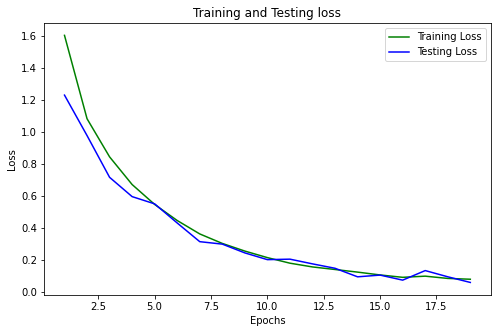

In [17]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_loss)+1), train_loss, 'g', label='Training Loss')
plt.plot(range(1, len(test_loss)+1), test_loss, 'b', label='Testing Loss')

plt.title('Training and Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Test on some random images

In [13]:
translate = {
    "bala": "Bala", 
    "black_winged_hatchetfish": "Black winged", 
    "blood_red_jewel_cichild": "Red cichild", 
    "blue_zebra_angelfish": "Zebra", 
    "bolivian_ram": "Bolivian", 
    "botia_striata_fish": "Botia", 
    "bristlenose_catfish": "Catfish", 
    "celestial_eye_goldfish": "Golfish", 
    "clown": "clown",
    "clown_loach": "clown_loach",
}

translate = {x:translate[x] for x in train_dataloader.dataset.dataset.classes}

In [14]:
# # Uncomment the below two lines if you want to use the pre trained model for 50 epoch
#model = torch.load('BasicCNN_Pytorch/model_50.pth', map_location=device) 
#model.eval()


denormalize = transforms.Compose([
    transforms.Normalize(mean = -mean/std, std = 1./std),
    transforms.ToPILImage()
])


with torch.no_grad():

    for impath in os.listdir('C:\\Users\\Asus\\Desktop\\Fish Classification With BasicCNN_Pytorch\\test_images'):
        try:
            image = Image.open(f'C:\\Users\\Asus\\Desktop\\Fish Classification With BasicCNN_Pytorch\\test_images{impath}')
        except:
            continue

        image = transforms.Compose([
            transforms.Resize(256),  
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])(image)

        image_tensor = image.view(1,3,256,256).to(device)

        moutput = model(image_tensor)
        moutput = nn.Softmax(dim=1)(moutput)[0]*100
        
        idx = moutput.argmax().data.item()
        oclass = list(translate.keys())[idx]
        moutput = moutput.int().data.cpu().numpy()

        display(denormalize(image))
        print(translate[oclass], ':', moutput[idx], '%', '\n\n')

model.train()
pass

### Try Training for another 50 epochs

In [15]:
model.train()

for epoch in range(51,61):
    train_loss.append(Train(epoch,200))
    test_loss.append(Test(epoch))

    print('\n')
    
    if epoch % 10 == 0:
        torch.save(model, 'model_'+str(epoch)+'.pth')

Epoch: [51]/(200/1313), Train Loss: 0.1198, Accuracy: 0.92, Time: 20.32 sec
Epoch: [51]/(400/1313), Train Loss: 0.2243, Accuracy: 0.92, Time: 38.28 sec
Epoch: [51]/(600/1313), Train Loss: 0.1406, Accuracy: 0.92, Time: 56.25 sec
Epoch: [51]/(800/1313), Train Loss: 0.1027, Accuracy: 0.93, Time: 74.25 sec
Epoch: [51]/(1000/1313), Train Loss: 0.1725, Accuracy: 0.93, Time: 92.30 sec
Epoch: [51]/(1200/1313), Train Loss: 0.5988, Accuracy: 0.93, Time: 110.40 sec
Epoch: [51], Test Loss: 0.2021, Accuracy: 0.94, Time: 21.36 sec


Epoch: [52]/(200/1313), Train Loss: 0.0543, Accuracy: 0.94, Time: 20.69 sec
Epoch: [52]/(400/1313), Train Loss: 0.3911, Accuracy: 0.94, Time: 38.79 sec
Epoch: [52]/(600/1313), Train Loss: 0.1719, Accuracy: 0.93, Time: 56.86 sec
Epoch: [52]/(800/1313), Train Loss: 0.2384, Accuracy: 0.93, Time: 75.07 sec
Epoch: [52]/(1000/1313), Train Loss: 0.1890, Accuracy: 0.94, Time: 93.23 sec
Epoch: [52]/(1200/1313), Train Loss: 0.1553, Accuracy: 0.94, Time: 111.33 sec
Epoch: [52], Tes

### Test the same Images

C:\Users\Asus\anaconda3\lib\site-packages\torchvision\transforms\functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
C:\Users\Asus\anaconda3\lib\site-packages\torchvision\transforms\functional.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std, dtype=torch.float32)


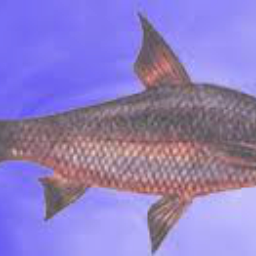

Bala : 96 % 




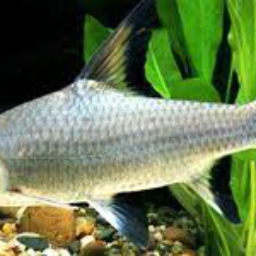

Bala : 99 % 




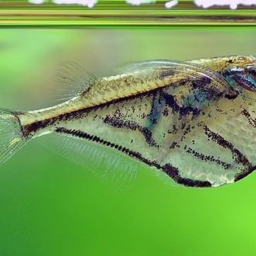

Black winged : 99 % 




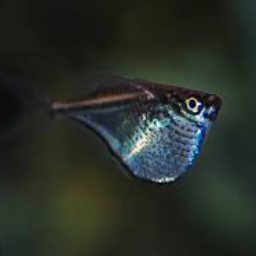

Black winged : 99 % 




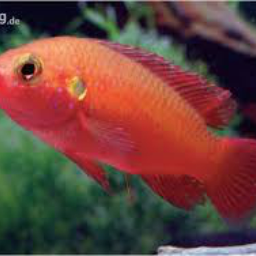

Red cichild : 99 % 




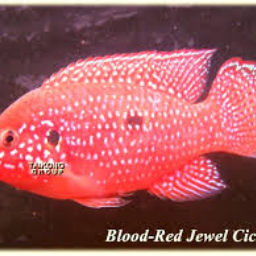

Red cichild : 99 % 




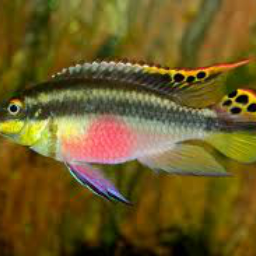

clown_loach : 89 % 




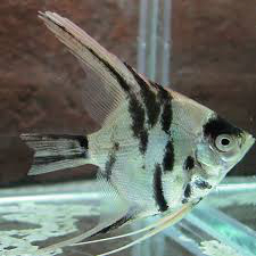

Zebra : 99 % 




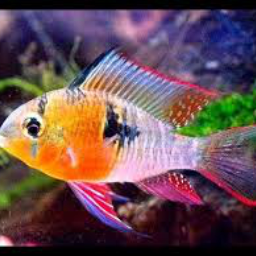

Bolivian : 100 % 




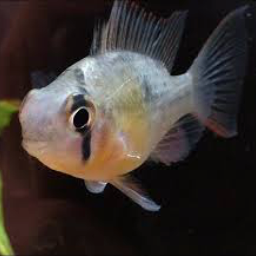

Bolivian : 99 % 




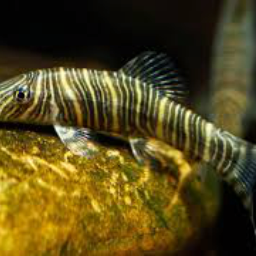

Botia : 100 % 




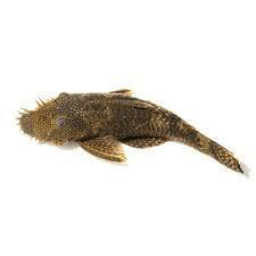

Black winged : 77 % 




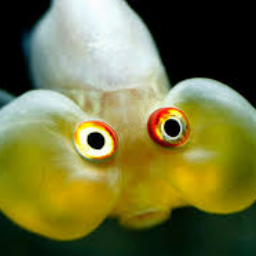

Golfish : 70 % 




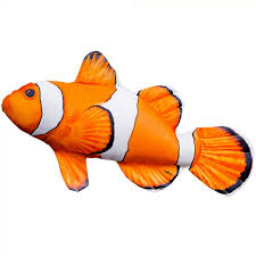

clown : 100 % 




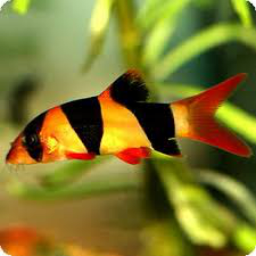

clown_loach : 100 % 




In [16]:
# # Uncomment the below two lines if you want to use the pre trained model for 100 epoch
#model = torch.load('BasicCNN_Pytorch/model_100.pth', map_location=device)
#model.eval()

denormalize = transforms.Compose([
    transforms.Normalize(mean = -mean/std, std = 1./std),
    transforms.ToPILImage()
])


with torch.no_grad():

    for impath in os.listdir('C:\\Users\\Asus\\Desktop\\Fish Classification With BasicCNN_Pytorch\\test_images\\'):
        try:
            image = Image.open(f'C:\\Users\\Asus\\Desktop\\Fish Classification With BasicCNN_Pytorch\\test_images\\{impath}')
        except:
            continue

        image = transforms.Compose([
            transforms.Resize(256),  
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])(image)

        image_tensor = image.view(1,3,256,256).to(device)

        moutput = model(image_tensor)
        moutput = nn.Softmax(dim=1)(moutput)[0]*100
        
        idx = moutput.argmax().data.item()
        oclass = list(translate.keys())[idx]
        moutput = moutput.int().data.cpu().numpy()

        display(denormalize(image))
        print(translate[oclass], ':', moutput[idx], '%', '\n\n')

model.train()
pass